In [2]:
import sys
import os
import random
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import pandas
import allel; print('scikit-allel', allel.__version__)
#%reload_ext memory_profiler
from collections import OrderedDict
import subprocess

TypeError: constructor returned NULL

In [152]:
callset_fn = '/mnt/popi/home/travc/proj/GenomeOceansIslands/calling/OI-1_var_pfilt.h5'
meta_fn = '/mnt/popi/home/travc/proj/GenomeOceansIslands/sample_info.csv'

ranges = ['2L']#:1-2e6', '3L:5e6-6e6']

# genotpye filtering
MIN_FMTDP = 2 # genotypes with less FMT:DP become uncalled

# locus filtering
FILTER_SNP = True
FILTER_BIALLELIC = True
MAX_MISSING = 10 # maximum allowed number of uncalled genotypes (None to disable)


accessibility_fn = '/data/home/travc/Ag1000g/phase1/AR3/accessibility/accessibility.h5'
INVERSION_GFF_FN = '/data/archive/reference/anno/AgamP3_travc_misc.gff'

In [3]:
def str2int(s):
    """return the int value of string, handles strings like 1e6 too"""
    rv = None
    try:
        rv = int(s)
    except ValueError:
        rv = int(float(s))
    return rv

def str2range(s):
    chrom = None
    start = 1
    stop = None
    tmp = s.split(':')
    chrom = tmp[0]
    if len(tmp)>1:
        if '-' in tmp[1]:
            tmp = tmp[1].split('-')
        else:
            tmp = tmp[1].split('..')
        start = str2int(tmp[0])
        if len(tmp)>1:
            stop = str2int(tmp[1])
    return (chrom, start, stop)

def test_str2range1():
    assert str2range('2L:1-1e6') == ('2L', 1, 1000000)
def test_str2range2():
    assert str2range('2L:1e6') == ('2L', 1000000, None)
def test_str2range3():
    assert str2range('2L') == ('2L', 1, None)
def test_str2range4():
    # very long ints should be preserved perfectly
    assert str2range('2L:1234567891011121314151617') == ('2L', 1234567891011121314151617, None)

# Run tests (@TCC remove for script)
test_str2range1()
test_str2range2()
test_str2range3()
test_str2range4()

In [4]:
def sampleIdxsByGroups(meta_df, *group_strings, group_field='group', idx_field='idx'):
    return meta_df[[ _ in group_strings for _ in meta_df[group_field] ]][idx_field] # for in list of strings

In [5]:
# Load callset file (doesn't actually load the data)
callset = h5py.File(callset_fn, mode='r')
all_sample_ids = [ _.decode('utf-8') for _ in callset[list(callset.keys())[0]]['samples'] ]

In [6]:
## Loading metadata (includes sample list)
df_meta = pandas.read_csv(meta_fn, index_col='sample')

# create sample_ids list and reorder to match callset file
sample_ids = list(df_meta.index)
sample_idxs = [all_sample_ids.index(x) for x in sample_ids]
tmp = list(zip(sample_idxs, sample_ids))
tmp.sort(key=lambda x: x[0])
sample_idxs, sample_ids = zip(*tmp)
# reorder the dataframe to match sample_ids (and callset)
df_meta = df_meta.reindex(sample_ids)
# append the callset idxs
df_meta['idx'] = pandas.Series(sample_idxs, index=df_meta.index)

df_meta

site   country                   group          28S  kdr  \
sample                                                                          
05TAKU0005        Takouti      Mali         allopatric Acol            M  NaN   
05TAKU0007        Takouti      Mali         allopatric Acol            M  NaN   
06TISS0021        Tissana      Mali         allopatric Acol            M  +;+   
06TISS0022        Tissana      Mali         allopatric Acol            M  +;+   
06TISS0023        Tissana      Mali         allopatric Acol            M  +;+   
06TISS0024        Tissana      Mali         allopatric Acol            M  +;+   
06TISS0026        Tissana      Mali         allopatric Acol            M  +;+   
06FOUM0032        Foumbot  Cameroon         allopatric Agam            S  NaN   
06FOUM0033        Foumbot  Cameroon         allopatric Agam            S  NaN   
06FOUM0035        Foumbot  Cameroon         allopatric Agam            S  NaN   
06FOUM0036        Foumbot  Cameroon         allopatric Agam            S  NaN   
06FOUM0037        Foumbot  Cameroon         allopatric Agam            S  NaN   
06SELI0045     Selinkenyi      Mali  backcross Acol - early  M-backcross  +;+   
06SELI0090     Selinkenyi      Mali  backcross Acol - early           F1  +;+   
06SELI0110     Selinkenyi      Mali  backcross Acol - early  M-backcross  W;+   
06SELI0120     Selinkenyi      Mali  backcross Acol - early  M-backcross  +;+   
06SELI0141     Selinkenyi      Mali  backcross Acol - early  M-backcross  +;+   
10SELI_O124    Selinkenyi      Mali   backcross Acol - late  M-backcross  NaN   
10SELI_O125    Selinkenyi      Mali   backcross Acol - late  M-backcross  NaN   
10SELI_O132    Selinkenyi      Mali   backcross Acol - late  M-backcross  NaN   
10SELI_O134    Selinkenyi      Mali   backcross Acol - late  M-backcross  NaN   
10SELI_O160    Selinkenyi      Mali   backcross Acol - late  M-backcross  NaN   
10SELI_O171    Selinkenyi      Mali   backcross Acol - late  M-backcross  NaN   
10SELI_O190    Selinkenyi      Mali   backcross Acol - late            M  NaN   
12SELI0002     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;W   
12SELI0003     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;W   
12SELI0006     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;+   
12SELI0009     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;+   
12SELI0012     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;W   
12SELI0013     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;+   
12SELI0021     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;W   
12SELI0026     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;W   
12SELI0029     Selinkenyi      Mali   backcross Acol - late            M  W;+   
12SELI0063     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;W   
12SELI0072     Selinkenyi      Mali   backcross Acol - late  M-backcross  W;+   
06SELI0027     Selinkenyi      Mali  backcross Agam - early  S-backcross  NaN   
06SELI0041     Selinkenyi      Mali  backcross Agam - early  S-backcross  +;+   
06SELI0096     Selinkenyi      Mali  backcross Agam - early  S-backcross  NaN   
06SELI0043     Selinkenyi      Mali                      F1           F1  W;+   
06SELI0107     Selinkenyi      Mali                      F1           F1  W;+   
06SELI0111     Selinkenyi      Mali                      F1           F1  W;+   
06SELI0112     Selinkenyi      Mali                      F1           F1  W;+   
02YORO0050   Yorobougoula      Mali  mostly allopatric Agam            S  NaN   
02YORO0052   Yorobougoula      Mali  mostly allopatric Agam            S  NaN   
02YORO0053   Yorobougoula      Mali  mostly allopatric Agam            S  NaN   
02YORO0054   Yorobougoula      Mali  mostly allopatric Agam            S  NaN   
02YORO0056   Yorobougoula      Mali  mostly allopatric Agam            S  NaN   
06SELI0015     Selinkenyi      Mali          sympatr

In [7]:
def loadGeneotypeArray(callset, 
                       range_string, 
                       MIN_FMTDP,
                       MAX_MISSING,
                       FILTER_SNP,
                       FILTER_BIALLELIC
                      ):
    """
    load the callset for given region into GenotypeArray
    do basic / first pass filtering as we go
    return ( position array, genotype array )
    """
    print('##',range_string,'#'*60)
    ch, start, stop = str2range(range_string)

    # make SortedIndex of positions so we can quickly locate_range
    print(ch, end='\t')
    pos = allel.SortedIndex(callset[ch]['variants']['POS'])
    print(pos.shape[0])

    # create the slice
    sl = pos.locate_range(start,stop)
    print(sl)
    pos = pos[sl]

    if len(pos) == 0: # no loci in slice
        g = []
    else:

        g = allel.GenotypeChunkedArray(callset[ch]['calldata']['genotype'])[sl].take(sample_idxs, axis=1)
        print(range_string, g.shape, sep='\t')

        num_loci_in = g.shape[0]
        flt = np.ones(num_loci_in, dtype=bool)

        # filter SNP
        if FILTER_SNP:
            flt_snp = callset[ch]['variants']['TYPE'][sl] == b'snp'
            flt = flt & flt_snp
            print('=',np.count_nonzero(flt), 'passing previous filters & SNP')

        # filter genotypes on FMT:DP
        if MIN_FMTDP > 0:
            genoflt_FMTDP = callset[ch]['calldata']['DP'][sl].take(sample_idxs, axis=1) < MIN_FMTDP
            g[genoflt_FMTDP] = [-1,-1]
            tmp_num_calls = g.shape[0]*g.shape[1]
            tmp = np.count_nonzero(genoflt_FMTDP)
            print('{} genotype call of {} ({:02.2f}%) fail FMT:DP filter'.format(
                    tmp, tmp_num_calls, 100*tmp/float(tmp_num_calls)))

        # filter max_missing (genotype calls)
        if MAX_MISSING is not None and MAX_MISSING < len(sample_idxs):
            flt_max_missing = np.sum(g.is_missing(), axis=1) <= MAX_MISSING
            tmp = num_loci_in - np.count_nonzero(flt_max_missing)
            print('{} loci of {} ({:02.2f}%) have > {} missing genotypes'.format(
                    tmp, num_loci_in, 100*tmp/float(num_loci_in), MAX_MISSING))
            flt = flt & flt_max_missing
        print('=',np.count_nonzero(flt), 'passing previous filters & max_missing')

        # fliter biallelic
        if FILTER_BIALLELIC:
            ac = g.count_alleles()
            flt_biallelic = ac.allelism() == 2
            flt = flt & flt_biallelic
            print('=',np.count_nonzero(flt), 'passing previous filters & biallelic')

        # apply filters
        g = g.compress(flt, axis=0)
        pos = pos.compress(flt, axis=0)
        print('\t',pos.shape[0])

        return pos, g

    
def loadMultipleGeneotypeArrays(callset, 
                       ranges, 
                       MIN_FMTDP,
                       MAX_MISSING,
                       FILTER_SNP,
                       FILTER_BIALLELIC
                      ):
    # load the callset for each region into a dict (by region) of GenotypeArrays

    pos_dict = OrderedDict()
    g_dict = OrderedDict()

    for rngstr in ranges:
        pos_dict[rngstr], g_dict[rngstr] = loadGeneotypeArray(callset, 
                                                               rngstr, 
                                                               MIN_FMTDP,
                                                               MAX_MISSING,
                                                               FILTER_SNP,
                                                               FILTER_BIALLELIC)
    return pos_dict, g_dict

In [9]:
pos, g = loadGeneotypeArray(callset, 
                           ranges[0], 
                           MIN_FMTDP,
                           MAX_MISSING,
                           FILTER_SNP,
                           FILTER_BIALLELIC)
g

## 2L ############################################################
2L	6774728
slice(0, 6774728, None)
2L	(6774728, 62, 2)
= 6050748 passing previous filters & SNP
176056411 genotype call of 420033136 (41.91%) fail FMT:DP filter
2826182 loci of 6774728 (41.72%) have > 10 missing genotypes
= 3948546 passing previous filters & max_missing
= 3924049 passing previous filters & biallelic
	 3924049


,0,1,2,3,4,...,57,58,59,60,61
0,0/0,./.,0/1,0/1,0/0,...,0/0,0/0,0/0,0/0,0/0
1,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/1,0/0,0/0
2,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
3,0/0,0/1,0/0,0/1,0/0,...,0/1,0/0,0/0,0/1,0/0
4,1/1,1/1,0/1,0/1,1/1,...,0/1,0/0,0/0,0/1,0/0


In [143]:
# Load plot annotation info
# inversions
# create a dict by chromosome of dicts by inversion name with [5'start, 5'end, 3'start, 3'end]
inversions = dict()
with open(INVERSION_GFF_FN) as fh:
    for line in fh:
        line = line.strip()
        if not line or line[0] == '#':
            continue
        tmp = line.split()
        tmp2 = tmp[8].split(';')
        if( tmp2[0].endswith("_breakpoint5'") or 
            tmp2[0].endswith("_breakpoint3'") ):
            ch = tmp[0]
            if not ch in inversions:
                inversions[ch] = dict()
            name, rest = tmp2[0].split('_')
            name = name.split('=')[1]
            if not name in inversions[ch]:
                inversions[ch][name] = [None,None,None,None]
            if tmp2[0].endswith("_breakpoint5'"):
                inversions[ch][name][0] = int(tmp[3])
                inversions[ch][name][1] = int(tmp[4])
            else:
                assert tmp2[0].endswith("_breakpoint3'")
                inversions[ch][name][2] = int(tmp[3])
                inversions[ch][name][3] = int(tmp[4])
                
for k,v in inversions.items():
    print(k,v)

2R {'2Rd': [31373828, 32531185, 41170384, 42344287], '2Rb': [18611501, 19978174, 25385661, 27287713], '2Ru': [31373828, 32531185, 34773589, 35916456], '2Rc': [27287714, 28379045, 30487221, 31373827], '2Rj': [3207587, 3656857, 14459087, 16462119]}
2L {'2La': [20056714, 21363564, 41240689, 42858303]}


In [144]:
def plot_inversions_on_chrom(inversions_on_chrom, ax, y_position=0.9, height=0.033, fontsize=11):
    trans = mpl.transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for k,v in inversions_on_chrom.items():
        print(k,v)
        tmp = np.array(v)#/1.0e6
        ht = height
        ypos = y_position
        # @TCC special HACK case for R2u
        if k == '2Ru':
            ypos = y_position - 2.3*height
        # actually put the patches on the axes
        ax.add_patch(mpl.patches.Rectangle((tmp[0],ypos-ht), tmp[1]-tmp[0], 2*ht,
                                           fc='.5', ec='none', transform=trans))
        ax.add_patch(mpl.patches.Rectangle((tmp[2],ypos-ht), tmp[3]-tmp[2], 2*ht,
                                           fc='.5', ec='none', transform=trans))
        ax.add_patch(mpl.patches.Rectangle((tmp[1],ypos-ht), tmp[2]-tmp[1], 2*ht,
                                           fc='#FFFF55', ec='none', transform=trans))
        ax.add_patch(mpl.patches.Rectangle((tmp[0],ypos-ht), tmp[3]-tmp[0], 2*ht,
                                           fc='none', ec='black', transform=trans))
        ax.text((tmp[1]+tmp[3])/2.0, ypos, r'\textsf{'+str(k)[len(chrom):]+'}', 
                ha='center', va='center',fontsize=fontsize, transform=trans)  

In [278]:
def calcFst(df_meta, groups1, groups2, window_size):
    group1_idxs = sampleIdxsByGroups(df_meta, groups1)
    group2_idxs = sampleIdxsByGroups(df_meta, groups2)
    #print(repr(group1_idxs))
    #print(repr(group2_idxs))
    ac1 = g.take(group1_idxs, axis=1).count_alleles()
    ac2 = g.take(group2_idxs, axis=1).count_alleles()
    window_step = int(window_size/2)
    fst, fst_windows, fst_counts = allel.stats.fst.windowed_hudson_fst(
                                                pos, ac1, ac2, 
                                                start=None, stop=None, 
                                                size=int(window_size), step=window_step, 
                                                windows=None, fill=np.nan)
    return fst, fst_windows, fst_counts

In [280]:
%%time
fst_window_size = 100e3
fst1, fst_windows1, fst_counts1 = calcFst(df_meta, 'allopatric Acol', 'mostly allopatric Agam', fst_window_size)
fst2, fst_windows2, fst_counts2 = calcFst(df_meta, 'sympatric Acol', 'sympatric Agam', fst_window_size)
fst3, fst_windows3, fst_counts3 = calcFst(df_meta, 'sympatric Acol', 'allopatric Acol', fst_window_size)
fst4, fst_windows4, fst_counts4 = calcFst(df_meta, 'sympatric Agam', 'mostly allopatric Agam', fst_window_size)

CPU times: user 4.84 s, sys: 1.76 s, total: 6.6 s
Wall time: 6.6 s


2La [20056714, 21363564, 41240689, 42858303]


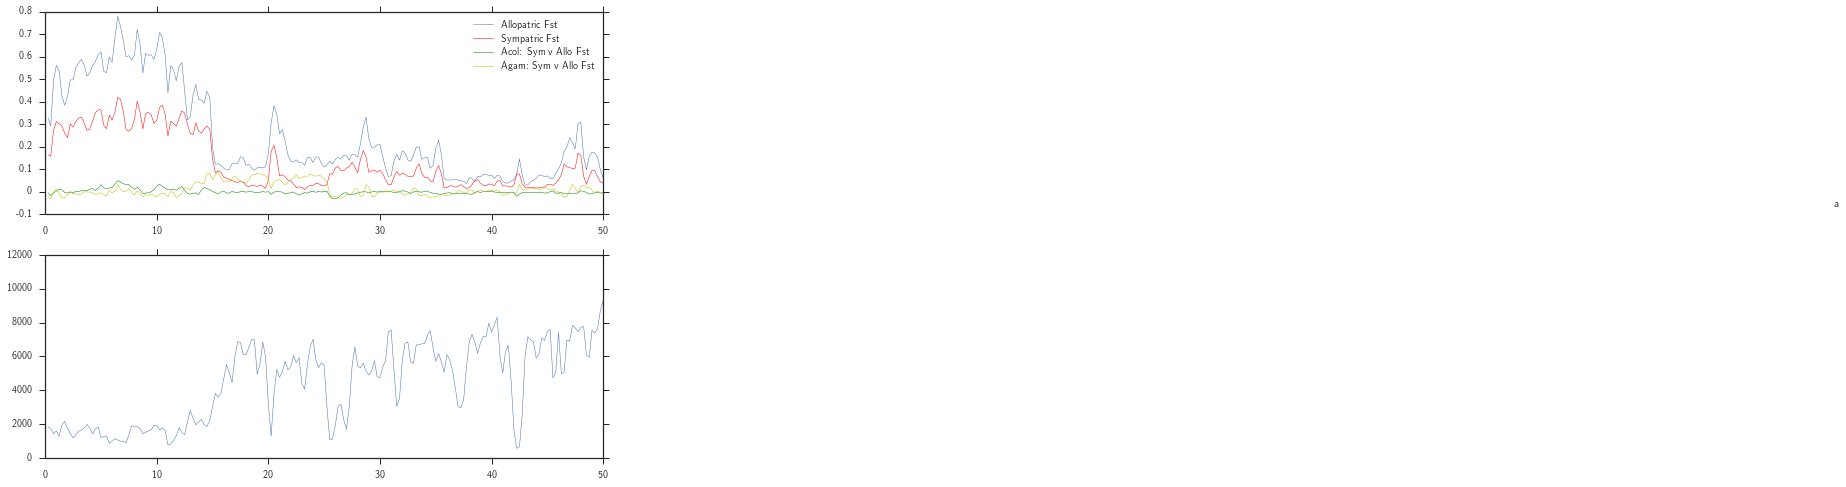

In [730]:
# Plot
mpl.rc('text', usetex=True)

# Plot
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,1,1)
ax1.plot(np.mean(fst_windows1, axis=1), fst1, lw=0.5, label='Allopatric Fst')
ax1.plot(np.mean(fst_windows2, axis=1), fst2, 'r-', lw=0.5, label='Sympatric Fst')
ax1.plot(np.mean(fst_windows3, axis=1), fst3, 'g-', lw=0.5, label='Acol: Sym v Allo Fst')
ax1.plot(np.mean(fst_windows4, axis=1), fst4, 'y-', lw=0.5, label='Agam: Sym v Allo Fst')

ax2 = fig.add_subplot(2,1,2)
ax2.plot(np.mean(fst_windows1, axis=1), fst_counts1, lw=0.5)

## Dxy ##
#ax1b = ax1.twinx()
#ax1b.plot(np.mean(dxy_windows, axis=1), dxy, 'k-', lw=0.5, label='Allopatric Dxy')
#ax1b.set_ylim([0,.15])

#ax2.plot(np.mean(dxy_windows, axis=1), dxy_n_bases, 'b-', lw=0.5)
#ax2b = ax2.twinx()
#ax2b.plot(np.mean(dxy_windows, axis=1), dxy_counts, 'r-', lw=0.5)

# inversion annotation
ch = '2L'
plot_inversions_on_chrom(inversions[ch], ax1, y_position=.05)

# Legend
ax1.legend()

# axes ticks and such
for ax in [ax1,ax2]:
    ax.set_yticklabels([r'\textsf{%g}'%(x) for x in ax.get_yticks()])
    ax.set_xticklabels([r'\textsf{%g}'%(x/1e6) for x in ax.get_xticks()]) # scale to MB

ax1.set_xlim((1,10e6))
ax2.set_xlim((1,10e6))
    
# Save figure
plt.savefig('tmp.svg')

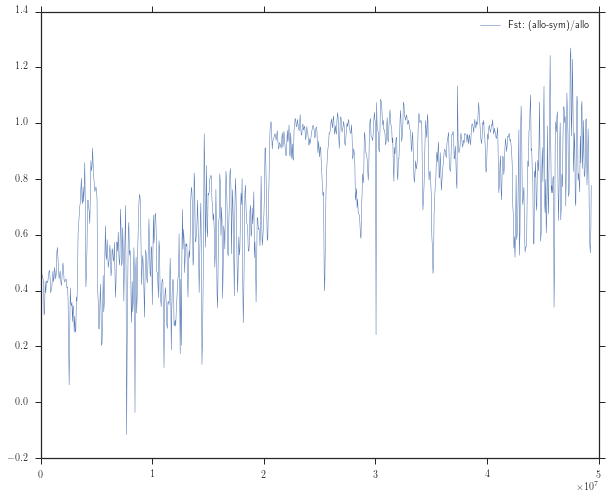

In [284]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(np.mean(fst_windows1, axis=1), (fst1-fst2)/fst1, lw=0.5, label='Fst: (allo-sym)/allo')
ax1.legend()

In [ ]:
# not sure how to properly interpret this... SE seems to increase with blen
allel.stats.fst.blockwise_hudson_fst(ac1, ac2, blen=20)

# F3 from patterson 2012

In [1054]:
window_size = int(50e3)
window_step = int(window_size/2)

In [1055]:
groupC_idxs = sampleIdxsByGroups(df_meta, 'sympatric Acol')
groupA_idxs = sampleIdxsByGroups(df_meta, 'allopatric Acol')
groupB_idxs = sampleIdxsByGroups(df_meta, 'allopatric Agam')#, 'mostly allopatric Agam')
#print(repr(groupC_idxs))
acC = g.take(groupC_idxs, axis=1).count_alleles()
acA = g.take(groupA_idxs, axis=1).count_alleles()
acB = g.take(groupB_idxs, axis=1).count_alleles()

T, B = allel.stats.admixture.patterson_f3(acC, acA, acB)

# windowed mean
wF3sM, windowssM, countssM = allel.stats.window.windowed_statistic(
                        pos, T, 
                        np.mean, 
                        start=None, stop=None, 
                        size=window_size, step=window_step, 
                        windows=None, fill=np.nan)

In [1056]:
groupC_idxs = sampleIdxsByGroups(df_meta, 'sympatric Agam')
groupA_idxs = sampleIdxsByGroups(df_meta, 'allopatric Acol')
groupB_idxs = sampleIdxsByGroups(df_meta, 'allopatric Agam')#, 'mostly allopatric Agam')
#print(repr(groupC_idxs))
acC = g.take(groupC_idxs, axis=1).count_alleles()
acA = g.take(groupA_idxs, axis=1).count_alleles()
acB = g.take(groupB_idxs, axis=1).count_alleles()

T, B = allel.stats.admixture.patterson_f3(acC, acA, acB)

# windowed mean
wF3sS, windowssS, countssS = allel.stats.window.windowed_statistic(
                        pos, T, 
                        np.mean, 
                        start=None, stop=None, 
                        size=window_size, step=window_step, 
                        windows=None, fill=np.nan)

In [1057]:
groupC_idxs = sampleIdxsByGroups(df_meta, 'backcross Acol - early')
groupA_idxs = sampleIdxsByGroups(df_meta, 'allopatric Acol')
groupB_idxs = sampleIdxsByGroups(df_meta, 'allopatric Agam')#, 'mostly allopatric Agam')
#print(repr(groupC_idxs))
acC = g.take(groupC_idxs, axis=1).count_alleles()
acA = g.take(groupA_idxs, axis=1).count_alleles()
acB = g.take(groupB_idxs, axis=1).count_alleles()

T, B = allel.stats.admixture.patterson_f3(acC, acA, acB)

# windowed mean
wF3bc1, windowsbc1, countsbc1 = allel.stats.window.windowed_statistic(
                        pos, T, 
                        np.mean, 
                        start=None, stop=None, 
                        size=window_size, step=window_step, 
                        windows=None, fill=np.nan)

In [1058]:
groupC_idxs = sampleIdxsByGroups(df_meta, 'backcross Acol - late')
groupA_idxs = sampleIdxsByGroups(df_meta, 'allopatric Acol')
groupB_idxs = sampleIdxsByGroups(df_meta, 'allopatric Agam')#, 'mostly allopatric Agam')
#print(repr(groupC_idxs))
acC = g.take(groupC_idxs, axis=1).count_alleles()
acA = g.take(groupA_idxs, axis=1).count_alleles()
acB = g.take(groupB_idxs, axis=1).count_alleles()

T, B = allel.stats.admixture.patterson_f3(acC, acA, acB)

# windowed mean
wF3bc2, windowsbc2, countsbc2 = allel.stats.window.windowed_statistic(
                        pos, T, 
                        np.mean, 
                        start=None, stop=None, 
                        size=window_size, step=window_step, 
                        windows=None, fill=np.nan)

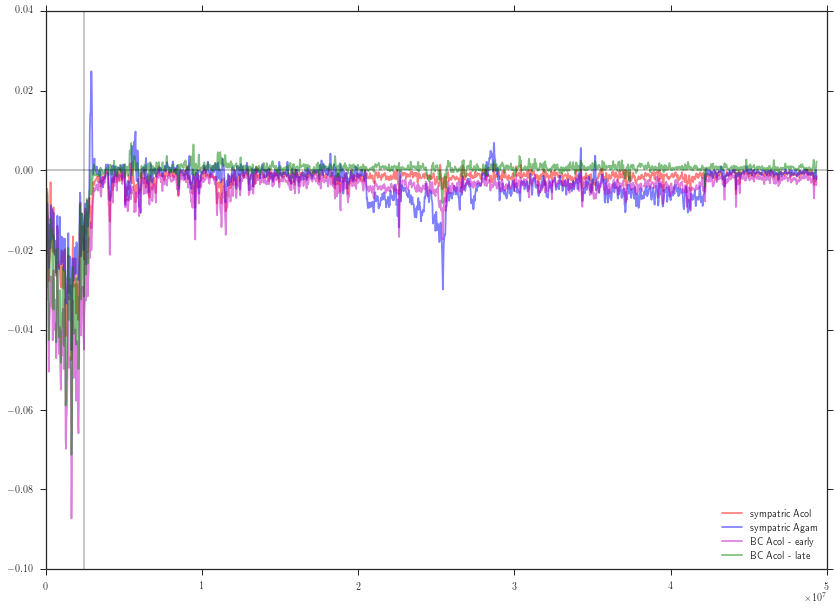

In [1061]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,1,1)
ax.plot(np.mean(windowssM,axis=1), wF3sM, 'r-', alpha=0.5, label='sympatric Acol')
ax.plot(np.mean(windowssS,axis=1), wF3sS, 'b-', alpha=0.5, label='sympatric Agam')
ax.plot(np.mean(windowsbc1,axis=1), wF3bc1, 'm-', alpha=0.5, label='BC Acol - early')
ax.plot(np.mean(windowsbc2,axis=1), wF3bc2, 'g-', alpha=0.5, label='BC Acol - late')
ax.legend(loc='lower right')

ax.axhline(y=0, color='black', alpha=0.25)
ax.axvline(x=2422652, color='black', alpha=0.25)

#ax.set_xlim((0,10e6))
#ax.set_ylim((-.1,.02))
#ax2 = fig.add_subplot(2,1,2)
#ax2 = ax.twinx()
#ax2.plot(np.mean(windows,axis=1), counts, 'k-', alpha=0.5)
#ax2.plot(np.mean(windowsbc1,axis=1), countsbc1, 'r-', alpha=0.5)
#ax2.plot(np.mean(windowsbc2,axis=1), countsbc2, 'g-', alpha=0.5)

# Dxy

In [189]:
## Load Accessiblity ##
accessibility = h5py.File(accessibility_fn, mode='r')
chrom = ranges[0]

is_accessible = accessibility[chrom]['is_accessible'][:]
pos_accessible = np.nonzero(is_accessible)[0] + 1 # positions are one-based
loci_accessible, _ = pos.locate_intersection(pos_accessible) # boolean array matching the loci in pos & g

In [668]:
groupA = ['allopatric Acol']
groupB = ['mostly allopatric Agam']
#groupB = ['allopatric Agam', 'mostly allopatric Agam']

window_size = int(100e3)
window_step = int(window_size/2.0)

In [669]:
## accessible Dxy ##
# accessible filter
g2 = g.compress(loci_accessible, axis=0)
pos2 = pos.compress(loci_accessible, axis=0)
# groups and allele counts
groupA_idxs = sampleIdxsByGroups(df_meta, *groupA)
groupB_idxs = sampleIdxsByGroups(df_meta, *groupB)
acA = g2.take(groupA_idxs, axis=1).count_alleles()
acB = g2.take(groupB_idxs, axis=1).count_alleles()
# accessible Dxy
dxy, dxy_windows, dxy_n_bases, dxy_counts = allel.stats.diversity.windowed_divergence(
                                            pos2, acA, acB, 
                                            start=None, stop=None, 
                                            size=window_size, step=window_step,
                                            windows=None,
                                            is_accessible=is_accessible,
                                            fill=np.nan)

In [670]:
# full Dxy
# groups and allele counts
groupA_idxs = sampleIdxsByGroups(df_meta, *groupA)
groupB_idxs = sampleIdxsByGroups(df_meta, *groupB)
acA = g.take(groupA_idxs, axis=1).count_alleles()
acB = g.take(groupB_idxs, axis=1).count_alleles()
dxyf, dxyf_windows, dxyf_n_bases, dxyf_counts = allel.stats.diversity.windowed_divergence(
                                            pos, acA, acB, 
                                            start=None, stop=None, 
                                            size=window_size, step=window_step,
                                            windows=None,
                                            #is_accessible=np.ones_like(is_accessible),
                                            fill=np.nan)

In [671]:
# variant sites only Dxy
foo = np.zeros_like(is_accessible)
foo[pos] = True
# groups and allele counts
groupA_idxs = sampleIdxsByGroups(df_meta, *groupA)
groupB_idxs = sampleIdxsByGroups(df_meta, *groupB)
acA = g.take(groupA_idxs, axis=1).count_alleles()
acB = g.take(groupB_idxs, axis=1).count_alleles()
dxyv, dxyv_windows, dxyv_n_bases, dxyv_counts = allel.stats.diversity.windowed_divergence(
                                            pos, acA, acB, 
                                            start=None, stop=None, 
                                            size=window_size, step=window_step,
                                            windows=None,
                                            is_accessible=foo,
                                            fill=np.nan)

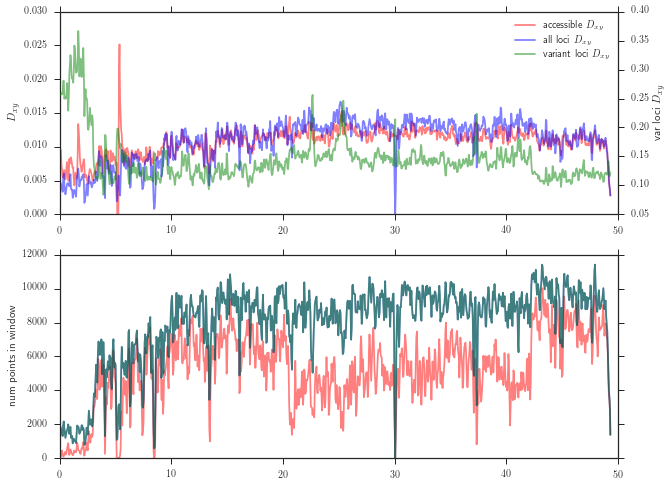

In [672]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2,1,1)
axb = ax.twinx()
ax.plot(np.mean(dxy_windows,axis=1)/1e6, dxy, 'r-', alpha=0.5, label=r'accessible $D_{xy}$')
#ax.set_ylim((0,.1))
ax.plot(np.mean(dxyf_windows,axis=1)/1e6, dxyf, 'b-', alpha=0.5, label='all loci $D_{xy}$')
axb.plot(np.mean(dxyv_windows,axis=1)/1e6, dxyv, 'g-', alpha=0.5, label='variant loci $D_{xy}$')

ax.set_ylabel(r'$D_{xy}$')
axb.set_ylabel(r'var loci $D_{xy}$')
handles, labels = ax.get_legend_handles_labels()
handlesb, labelsb = axb.get_legend_handles_labels()
ax.legend(handles+handlesb, labels+labelsb)

ax = fig.add_subplot(2,1,2)
ax.plot(np.mean(dxy_windows,axis=1)/1e6, dxy_counts, 'r-', alpha=0.5)
#ax.set_ylim((0,.1))
#axb = ax.twinx()
ax.plot(np.mean(dxyf_windows,axis=1)/1e6, dxyf_counts, 'b-', alpha=0.5)
ax.plot(np.mean(dxyv_windows,axis=1)/1e6, dxyv_counts, 'g-', alpha=0.5)
ax.set_ylabel(r'num points in window')


In [673]:
## Depth ??

In [315]:
def readFaidx(faidx_filename, verbose=0):
    if( verbose >= 1 ):
        print('Reading faidx file "'+faidx_filename+'"', file=sys.stderr)
    fai = OrderedDict()
    with open(faidx_filename) as infile:
        for l in infile:
            l = l.partition('#')[0].rstrip()
            if( not l ):
                continue
            l = l.split()
            assert l[0] not in fai
            fai[l[0]] = {'length':int(l[1]),
                         'offset':int(l[2]),
                         'line_len':int(l[3]),
                         'bline_len':int(l[4]),
                        }
    return fai

In [505]:
def runSambambaDepth(bam_filenames, 
                     chrom, 
                     start=None, 
                     stop=None,
                     chrom_len=None,
                     mapping_quality_threshold=30, 
                     base_quality_threshold=20,
                     proper_pair=False, # freebayes does not require proper_pair
                     filter_test=False,
                     dtype='uint16'):
    """returns numpy array (1d) with depth for each position
    positions are 0-based starting with 'start', 
    so depth[12-start] is the ones-based position 12 in the sequence"""
    assert chrom_len is not None or stop is not None
    # allocate storage
    if stop is not None:
        if start is None:
            length = stop
        else:
            length = stop-start+1
    else:
        if start is None:
            length = chrom_len
        else:
            length = chrom_len-start+1
    length = length
    print('allocating:',length)
    out = np.zeros((length), dtype=dtype)
    # compose and run command
    cmd = [ SAMBAMBA_EXEC,
            'depth','base',
            '-q', str(int(base_quality_threshold)), # 20 is freebayes standard
            ]
    # filter part of command
    cmd.append('-F')
    cmd.append('mapping_quality > {}'.format(mapping_quality_threshold)+
               ' and not duplicate'+
               ' and not failed_quality_control'+
               ' and not secondary_alignment'+
               ' and not supplementary')
    if proper_pair:
        cmd[-1] += ' and proper_pair'
    if filter_test:
         cmd[-1] += ' and proper_pair'
    # range
    if start is None:
        if stop is None:
            start = 1
            cmd.extend(['-L', chrom])
    else:
        if stop is None:
            cmd.extend(['-L', chrom+':'+str(int(start))])
        else:
            cmd.extend(['-L', chrom+':'+str(int(start))+'-'+str(int(stop))])
    for v in bam_filenames:
        cmd.append(v)
    print("Running:",cmd, file=sys.stderr)
    sys.stderr.flush()
    proc = subprocess.Popen(cmd, stdout=subprocess.PIPE, universal_newlines=True, stderr=subprocess.DEVNULL)
    # use cut to simplify parsing
    cmd2 = ['/usr/bin/cut', '-f', '2,3']
    proc2 = subprocess.Popen(cmd2, stdin=proc.stdout, stdout=subprocess.PIPE)
    # parse output
    offset = start - 1 # sambamba outputs 0-based POS
    next(proc2.stdout)
    for line in proc2.stdout:
        line = line.decode('utf-8').split('\t')
        out[int(line[0])-offset] = int(line[1])    
    return out


In [ ]:
REF_FAIDX_FN = '/data/archive/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa.fai'
SAMBAMBA_EXEC = '/home/travc/install/sambamba'

In [568]:
fai = readFaidx(REF_FAIDX_FN)

In [640]:
%%time
chrom = '2L'
start = 1
stop =  None
depth = runSambambaDepth(['/mnt/popi/home/travc/seq_v2/AgamP4/samples/05TAKU0005/05TAKU0005.bam'], 
                        chrom, start=start, stop=stop,
                        chrom_len=fai['2L']['length'],
                        proper_pair=False)

Running: ['/home/travc/install/sambamba', 'depth', 'base', '-q', '20', '-F', 'mapping_quality > 30 and not duplicate and not failed_quality_control and not secondary_alignment and not supplementary', '-L', '2L:1', '/mnt/popi/home/travc/seq_v2/AgamP4/samples/05TAKU0005/05TAKU0005.bam']


allocating: 49364325
CPU times: user 58.9 s, sys: 512 ms, total: 59.4 s
Wall time: 1min 33s


In [641]:
depth2 = runSambambaDepth(['/mnt/popi/home/travc/seq_v2/AgamP4/samples/02YORO0056/02YORO0056.bam'], 
                        chrom, start=start, stop=stop,
                        chrom_len=fai['2L']['length'],
                        proper_pair=False)

Running: ['/home/travc/install/sambamba', 'depth', 'base', '-q', '20', '-F', 'mapping_quality > 30 and not duplicate and not failed_quality_control and not secondary_alignment and not supplementary', '-L', '2L:1', '/mnt/popi/home/travc/seq_v2/AgamP4/samples/02YORO0056/02YORO0056.bam']


allocating: 49364325


In [643]:
md1 = np.median(depth)
md2 = np.median(depth2)
print(md1, md2)

13.0 7.0


(0, 6)

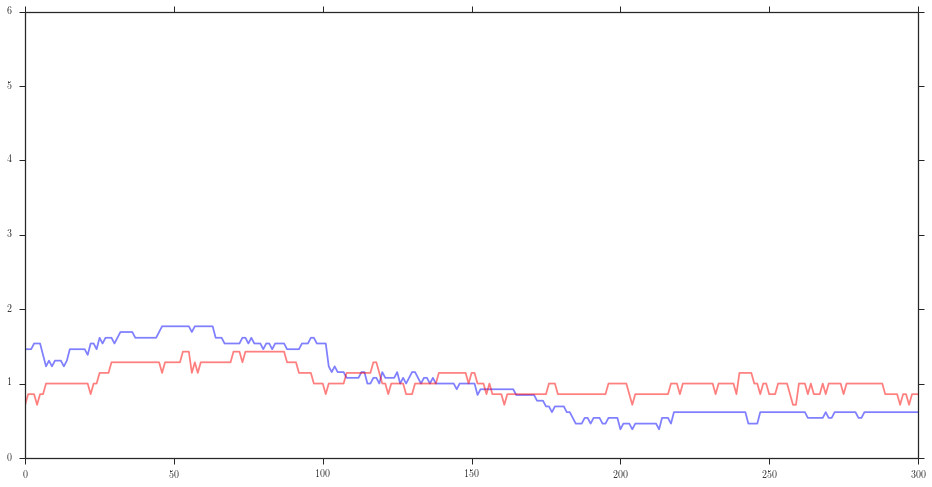

In [567]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
ax.plot(depth/md1, 'b-', alpha=0.5)
#axb = ax.twinx()
ax.plot(depth2/md2, 'r-', alpha=0.5)
ax.set_ylim((0,6))

In [515]:
depth

array([12, 12, 12, ..., 17, 18, 18], dtype=uint16)

In [516]:
depth_pp

array([ 9,  9,  9, ..., 17, 18, 18], dtype=uint16)

# Polarization metrics

In [882]:
groupA = ['allopatric Acol']
#groupB = ['mostly allopatric Agam']
groupB = ['allopatric Agam', 'mostly allopatric Agam']
#groupA = ['sympatric Acol']
#groupB = ['sympatric Agam']
#groupB = ['backcross Acol - late']
groupA_idxs = sampleIdxsByGroups(df_meta, *groupA)
groupB_idxs = sampleIdxsByGroups(df_meta, *groupB)
print(len(groupA_idxs), len(groupB_idxs))
acA = g.take(groupA_idxs, axis=1).count_alleles()
acB = g.take(groupB_idxs, axis=1).count_alleles()
afA = acA.to_frequencies()
afB = acB.to_frequencies()

7 10


### fixed differences

In [883]:
fltA = np.logical_and(afA[:,0] == 1, afB[:,0] == 0)
fltB = np.logical_and(afA[:,1] == 1, afB[:,1] == 0)
flt = np.logical_or(fltA, fltB)
print(np.count_nonzero(flt),'out of',flt.shape[0])

2318 out of 3924049


(0.5, 1.5)

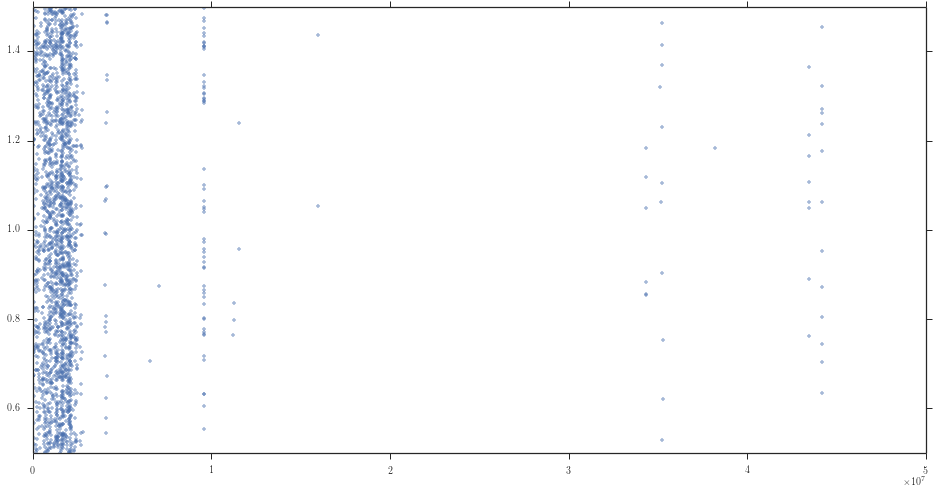

In [884]:
jitter = np.random.uniform(low=.5, high=1.5, size=flt.shape)

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,1,1)
ax.plot(pos, flt*jitter, '.', alpha=0.5)
ax.set_ylim((.5,1.5))
#ax.set_xlim((9.55e6,9.6e6))

# $\pi$ (aka: sequence diversity)

In [974]:
groups = [['allopatric Acol'],
          ['mostly allopatric Agam'],
          #['allopatric Agam'],
          ['sympatric Acol'],
          ['sympatric Agam'],
          ['backcross Acol - early'],
          ]

winsize = int(250e3)
winstep = int(winsize/2.0)
pis = []
counts = []

for grps in groups:
    group_idxs = sampleIdxsByGroups(df_meta, *grps)
    print(grps, len(group_idxs))

    ac = g.take(group_idxs, axis=1).count_alleles()

    pi, wins, n_bases, cnt = allel.stats.diversity.windowed_diversity(pos, ac, 
                                size=winsize, step=winstep,
                                is_accessible=None)#is_accessible)
    pis.append(pi)
    counts.append(cnt)

['allopatric Acol'] 7
['mostly allopatric Agam'] 5
['sympatric Acol'] 8
['sympatric Agam'] 7
['backcross Acol - early'] 5


(0, 10000000.0)

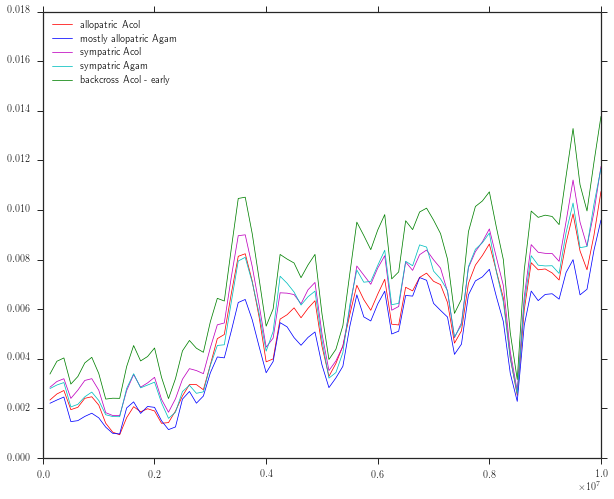

In [975]:
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1,1,1)
lss = ['r-', 'b-', 'm-', 'c-', 'g-']

for i,pi in enumerate(pis):
    ax1.plot(np.mean(wins, axis=1), pi, 
             lss[i], lw=0.75,
             label=' & '.join(groups[i]))
ax1.legend(loc='upper left')
#ax2 = fig.add_subplot(2,1,2)
#ax2.plot(np.mean(wins, axis=1), counts, lw=0.5)
ax1.set_xlim((0,10e6))

In [858]:
#groupA = ['allopatric Acol']
#groupB = ['mostly allopatric Agam']
#groupB = ['allopatric Agam', 'mostly allopatric Agam']
groupA = ['sympatric Acol']
groupB = ['sympatric Agam']
groupA_idxs = sampleIdxsByGroups(df_meta, *groupA)
groupB_idxs = sampleIdxsByGroups(df_meta, *groupB)
print(len(groupA_idxs), len(groupB_idxs))
acA = g.take(groupA_idxs, axis=1).count_alleles()
acB = g.take(groupB_idxs, axis=1).count_alleles()
afA = acA.to_frequencies()
afB = acB.to_frequencies()

8 7


In [859]:
fltA = np.logical_and(afA[:,0] > 0.5, afB[:,0] == 0)
fltB = np.logical_and(afA[:,1] > 0.5, afB[:,1] == 0)
flt = np.logical_or(fltA, fltB)
print(np.count_nonzero(flt),'out of',flt.shape[0], '('+str(100*np.count_nonzero(flt)/flt.shape[0])+'%)')

1353 out of 3924049 (0.03447969176735561%)


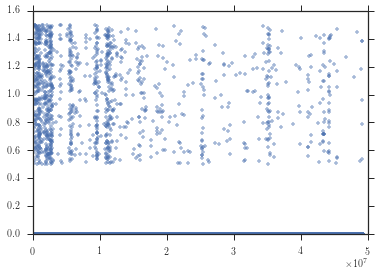

In [860]:
jitter = np.random.uniform(low=.5, high=1.5, size=flt.shape)
plt.plot(pos, flt*jitter, '.', alpha=0.5)

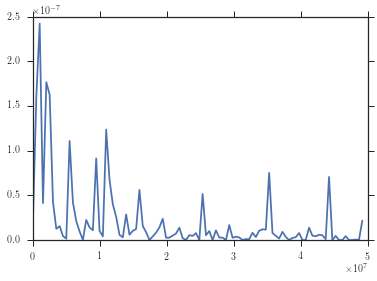

In [861]:
sns.kdeplot(pos.compress(flt,axis=0), bw=0.005)

In [976]:
groupA = ['allopatric Acol']
groupB = ['mostly allopatric Agam']
#groupB = ['allopatric Agam', 'mostly allopatric Agam']
#groupA = ['sympatric Acol']
#groupB = ['sympatric Agam']
groupA_idxs = sampleIdxsByGroups(df_meta, *groupA)
groupB_idxs = sampleIdxsByGroups(df_meta, *groupB)
print(len(groupA_idxs), len(groupB_idxs))
acA = g.take(groupA_idxs, axis=1).count_alleles()
acB = g.take(groupB_idxs, axis=1).count_alleles()
afA = acA.to_frequencies()
afB = acB.to_frequencies()

7 5


In [1076]:
fltA = np.logical_and(afA == 1, afB == 0)
fltB = np.logical_and(afA == 0, afB == 1)
#flt = np.logical_or(fltA, fltB)
print(np.count_nonzero(fltA.sum(axis=1)),'out of',flt.shape[0], 
      '({:.3f}%)'.format(100*np.count_nonzero(flt)/flt.shape[0]))

2791 out of 3924049 (0.059%)


In [1100]:
#groupC = ['sympatric Acol']
#groupC = ['sympatric Agam']
#groupC = ['backcross Acol - early']
groupC = ['backcross Acol - late']
groupC_idxs = sampleIdxsByGroups(df_meta, *groupC)
print(len(groupC_idxs))
acC = g.take(groupC_idxs, axis=1).count_alleles()
afC = acC.to_frequencies()

18


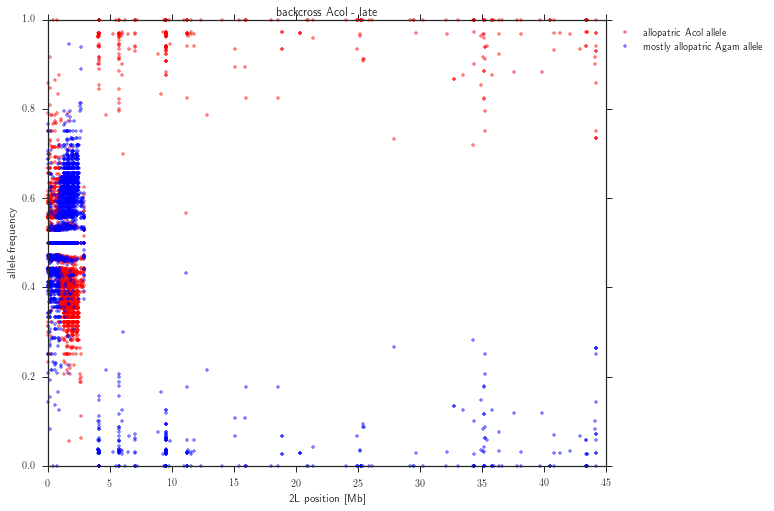

In [1101]:
# filter out loci which fail both fltA and fltB (less pts to plot)
flt = np.logical_or(fltA.sum(axis=1) > 0, fltB.sum(axis=1) > 0)
posf = pos.compress(flt, axis=0)
affC = afC.compress(flt, axis=0)
fltfA = fltA.compress(flt, axis=0)
fltfB = fltB.compress(flt, axis=0)

fooA = (affC * fltfA).sum(axis=1)
fooB = (affC * fltfB).sum(axis=1)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1,1,1)

ax.plot(posf/1e6, fooA, 
        'r.', alpha=0.5, clip_on=False,
        label=' & '.join(groupA)+' allele')
ax.plot(posf/1e6, fooB,
        'b.', alpha=0.5, clip_on=False,
        label=' & '.join(groupB)+' allele')

ax.set_xlabel(chrom+' position [Mb]')
ax.set_ylabel('allele frequency')
ax.set_title(' & '.join(groupC))
lgd = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.savefig('2L_fixed_allele_freq '+' & '.join(groupC)+'.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [1035]:
afC[np.nonzero(afC*fltA)]

array([ 0.71428571,  0.75      ,  0.75      , ...,  0.8125    ,
        0.8125    ,  0.64285714])

In [1036]:
afC[np.nonzero(afC*fltB)]

array([ 0.28571429,  0.25      ,  0.25      , ...,  0.1875    ,
        0.1875    ,  0.35714286])

In [1042]:
(afC*fltA).sum(axis=1)[29]

0.7142857142857143

In [1]:
sns.kdeplot(pos.compress(flt,axis=0), bw=0.005)

NameError: name 'sns' is not defined

In [773]:
np.maximum(afA[0:100,:], afB[0:100,:]).sum(axis=1)/2.0

array([ 0.6       ,  0.5       ,  0.5       ,  0.625     ,  0.91666667,
        0.5       ,  0.5       ,  0.75      ,  0.54166667,  0.5       ,
        0.54166667,  0.75      ,  0.54166667,  0.54166667,  0.75      ,
        0.75      ,  0.5       ,  0.75      ,  0.70833333,  0.55      ,
        0.70833333,  0.5       ,  0.65      ,  0.5       ,  0.625     ,
        0.5       ,  0.6875    ,  0.6       ,  0.5       ,  1.        ,
        0.75      ,  0.5       ,  0.75      ,  0.66666667,  0.5       ,
        0.75      ,  1.        ,  0.5       ,  0.5       ,  1.        ,
        0.5       ,  0.5625    ,  0.5       ,  0.54166667,  0.5       ,
        0.5       ,  0.625     ,  0.5       ,  0.7       ,  0.5       ,
        0.5       ,  0.65      ,  0.5       ,  0.625     ,  0.5       ,
        0.75      ,  0.5       ,  0.5       ,  0.65833333,  0.58333333,
        0.8       ,  0.575     ,  0.5       ,  0.5       ,  0.5       ,
        0.5       ,  0.5       ,  0.54166667,  0.54166667,  0.65